In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext memory_profiler

#### Стохастический градиентный спуск (общий вид)

In [2]:
def deviation(x, y):
    return lambda b: sum((y[i] - b[:, 0].dot(x[i])) ** 2 for i in range(len(y)))


def gradient_descent(lr, get_next_point, deviation, batch_size, points_number, max_iter_num=300, eps=1e-4):
    result = np.array([[0], [0]])
    log = []
    diff = deviation(result)
    for i in range(max_iter_num):
        for batch_id in range(1, points_number, points_number // batch_size):
            id = np.random.randint(batch_id, batch_id + points_number // batch_size)
            result = get_next_point(result, id, lr)
        prev_diff, diff = diff, deviation(result)
        log.append([result[0, 0], result[1, 0]])
        if abs(diff - prev_diff) < eps:
            break
    # print(i + 1)
    return result, np.array(log)

In [3]:
def test_function(x_raw, x, y, f):
    def draw(n):
        plt.scatter(x_raw, y)
        plt.plot(x_raw, x.dot(f(n)[0]), c='yellow')
        plt.show()


    draw(1)   # SGD
    draw(50)  # MinibatchGD
    draw(100) # NGD

In [4]:
# Init data for running methods
x_raw = 2 * np.random.rand(100, 1)
# Set each point's 0th coefficient to 1 so that we can use cross product to calculate the const term
x = np.c_[np.ones((len(x_raw), 1)), x_raw]
y = 5 * x_raw + np.random.rand(100, 1)

## 2.1

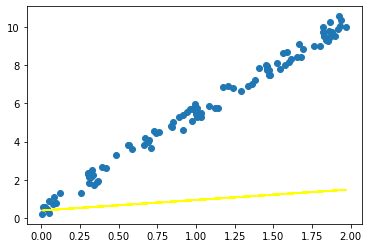

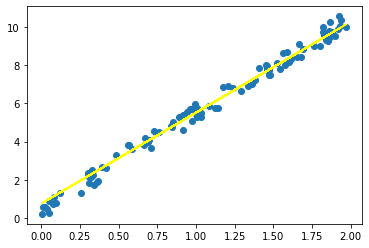

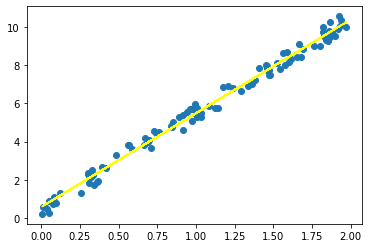

In [5]:
def gradient_descent_next_point(x, y):
    def get_next_point(result, id, lr):
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        seq = xi.T.dot((xi.dot(result)) - yi)
        return result - lr * seq

    return get_next_point


def call_gradient_descent(batch_size: int):
    return gradient_descent(1e-3, gradient_descent_next_point(x, y), deviation(x, y), batch_size, len(y))


test_function(x_raw, x, y, call_gradient_descent)

## 2.2

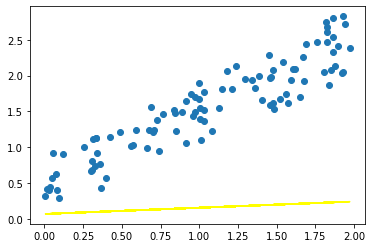

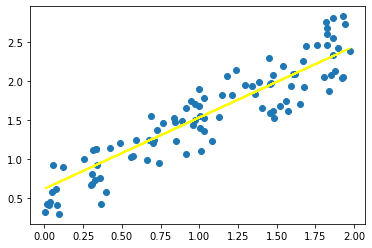

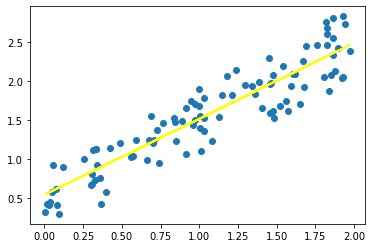

In [6]:
def call_scaling(batch_size):
    return gradient_descent(1e-3, gradient_descent_next_point(x, scaled), deviation(x, scaled), batch_size, len(y))


beta = 0.8
a = np.random.rand(100, 1)
scaled = np.array([beta * a[i - 1] + (1 - beta) * y[i] for i in range(100)])
test_function(x_raw, x, scaled, call_scaling)

## 2.3

In [7]:
def gen_to_next(gen):
    def next_getter(*args):
        next(gen)
        return gen.send(args)
    return next_getter

### Momentum

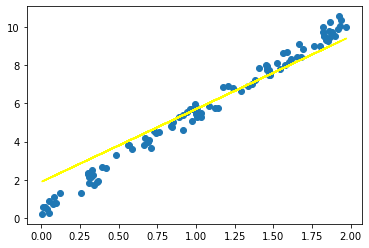

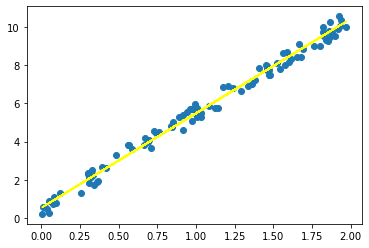

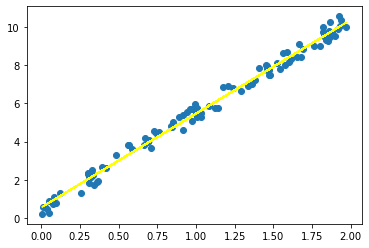

In [8]:
def momentum_next_point(x, y, beta):
    seq = 0

    while True:
        (result, id, lr) = yield
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        seq = beta * seq + (1 - beta) * xi.T.dot((xi.dot(result)) - yi)
        yield result - lr * seq


def call_momentum(batch_size):
    return gradient_descent(1e-2, gen_to_next(momentum_next_point(x, y, 0.8)), deviation(x, y), batch_size, len(y))


test_function(x_raw, x, y, call_momentum)


### Nesterov

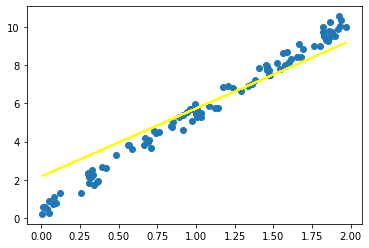

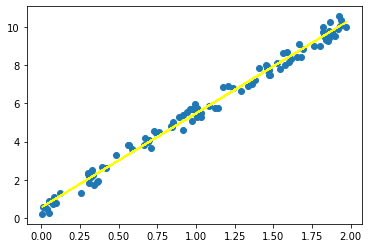

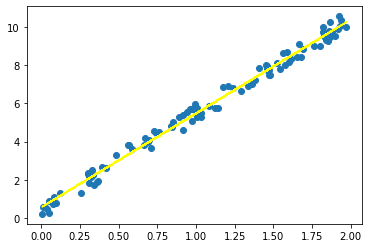

In [9]:
def nesterov_next_point(x, y, beta):
    seq = 0

    while True:
        (result, id, lr) = yield
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        seq = beta * seq + lr * xi.T.dot((xi.dot(result)) - yi)
        yield result - seq


def call_nesterov(batch_size):
    return gradient_descent(1e-3, gen_to_next(nesterov_next_point(x, y, 0.8)), deviation(x, y), batch_size, len(y))


test_function(x_raw, x, y, call_nesterov)


### AdaGrad

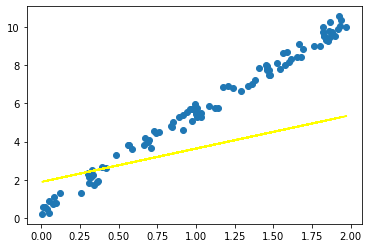

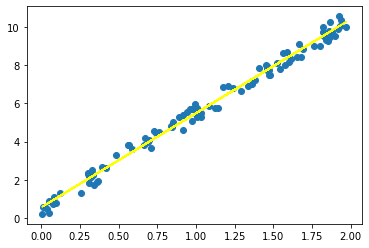

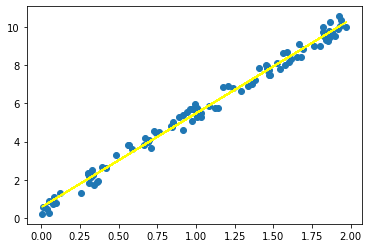

In [10]:
def ada_grad_next_point(x, y):
    seq = 0

    while True:
        (result, id, lr) = yield
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        grad = xi.T.dot((xi.dot(result)) - yi)
        seq += grad ** 2
        yield result - np.divide(lr, np.sqrt(seq)) * grad


def call_ada_grad(batch_size):
    return gradient_descent(0.2, gen_to_next(ada_grad_next_point(x, y)), deviation(x, y), batch_size, len(y))


test_function(x_raw, x, y, call_ada_grad)

### RMS Prop

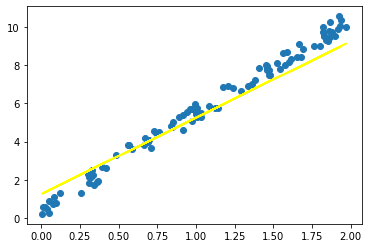

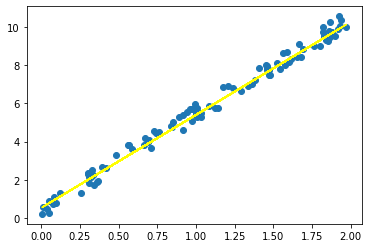

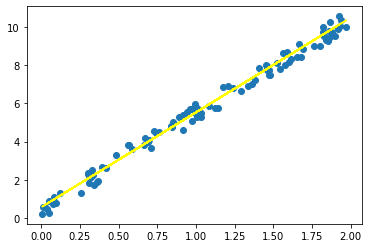

In [11]:
def rms_prop_next_point(x, y, beta):
    seq = 0

    while True:
        (result, id, lr) = yield
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        grad = xi.T.dot((xi.dot(result)) - yi)
        seq = beta * seq + (1 - beta) * grad ** 2
        yield result - np.divide(lr, np.sqrt(seq)) * grad


def call_rms_prop(batch_size):
    return gradient_descent(0.1, gen_to_next(rms_prop_next_point(x, y, 0.8)), deviation(x, y), batch_size, len(y))


test_function(x_raw, x, y, call_rms_prop)

### Adam

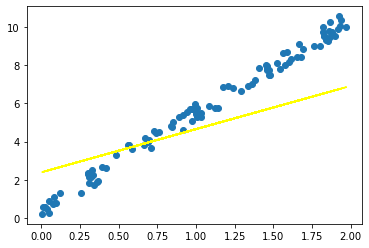

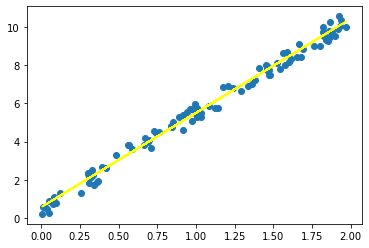

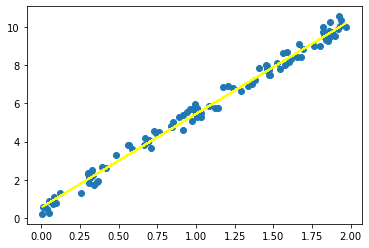

In [12]:
def adam_next_point(x, y, beta, gamma):
    seq1 = 0
    seq2 = 0

    while True:
        (result, id, lr) = yield
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        grad = xi.T.dot((xi.dot(result)) - yi)
        seq1 = beta * seq1 + (1 - beta) * grad
        seq2 = gamma * seq2 + (1 - gamma) * grad ** 2
        yield result - lr * np.divide(seq1, np.sqrt(seq2))


def call_adam(batch_size):
    return gradient_descent(1e-2, gen_to_next(adam_next_point(x, y, 0.8, 0.8)), deviation(x, y), batch_size, len(y))


test_function(x_raw, x, y, call_adam)

## 2.4

| \                       | Momentum   | Nesterov   | AdaGrad    | RMSProp    | Adam       |
|-------------------------|------------|------------|------------|------------|------------|
| Среднее время работы, с | 0.078      | 0.093      | 0.172      | 0.015      | 0.062      |
| Среднее число итераций  | 39         | 75         | 118        | 6          | 29         |
| Peak memory             | 111.08 MiB | 111.08 MiB | 111.08 MiB | 111.08 MiB | 111.08 MiB |

In [13]:
print("Momentum")
%time call_momentum(100)
%memit call_momentum(100)
print()

print("Nesterov")
%time call_nesterov(100)
%memit call_nesterov(100)
print()

print("AdaGrad")
%time call_ada_grad(100)
%memit call_ada_grad(100)
print()

print("RMSProp")
%time call_rms_prop(100)
%memit call_rms_prop(100)
print()

print("Adam")
%time call_adam(100)
%memit call_adam(100)
print()

Momentum
CPU times: user 56.7 ms, sys: 4.36 ms, total: 61.1 ms
Wall time: 316 ms
peak memory: 115.04 MiB, increment: 0.16 MiB

Nesterov
CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 534 ms
peak memory: 115.18 MiB, increment: 0.00 MiB

AdaGrad
CPU times: user 183 ms, sys: 0 ns, total: 183 ms
Wall time: 858 ms
peak memory: 115.18 MiB, increment: 0.00 MiB

RMSProp
CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 39.4 ms
peak memory: 115.18 MiB, increment: 0.00 MiB

Adam
CPU times: user 54.4 ms, sys: 227 µs, total: 54.6 ms
Wall time: 266 ms
peak memory: 115.18 MiB, increment: 0.00 MiB



## 2.5

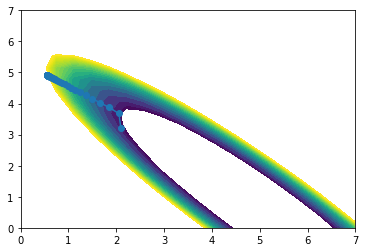

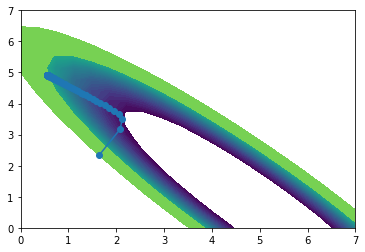

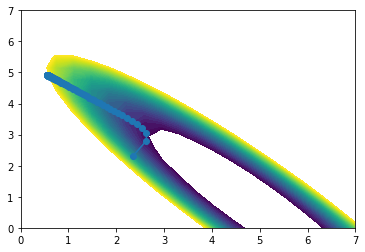

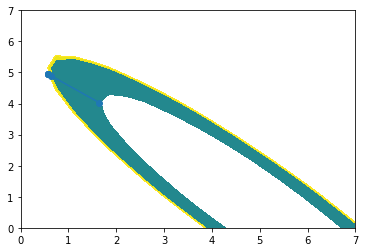

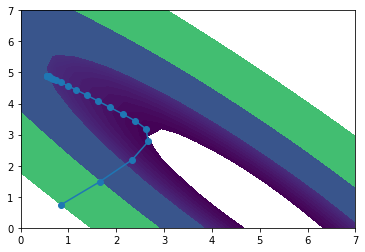

In [14]:
def f(p):
    return np.sum((p[0] * x + p[1] - y) ** 2)


def draw_graphic(f, points):
    t = np.linspace(0, 7, 20)
    X, Y = np.meshgrid(t, t)
    Z = np.array([[f([X[i, j], Y[i, j]]) for j in range(len(t))] for i in range(len(t))])
    plt.plot(points[:, 0], points[:, 1], 'o-')
    plt.contourf(X, Y, Z, levels=sorted([f(p) for p in points]))
    plt.show()


for algo in [call_momentum, call_nesterov, call_ada_grad, call_rms_prop, call_adam]:
    draw_graphic(f, algo(100)[1])